In [1]:
import numpy as np
import casadi
import matplotlib.pyplot as plt

In [17]:
m = 1
k = 1
c = 0.5

nx = 2 #状態変数の次元
nu = 1 #制御変数の次元
no = 1 #観測変数の次元

# 後退ホライズン等
T = 1
N = 20
dt = T/N

# 制約条件
x_lb = [-np.inf,-np.inf]
x_ub = [np.inf,np.inf]

total = nx*(N+1) + nu*N + no*N + nx

In [18]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    A = casadi.DM([
        [0,1],
        [-k/m,-c/m]
    ])

    B = casadi.DM([
        [0],
        [1/m]
    ])

    states_dot = A @ states + B @ ctrls

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    k1 = f(x=states,u=ctrls)["x_dot"]
    k2 = f(x=states+dt*k1/2,u=ctrls)["x_dot"]
    k3 = f(x=states+dt*k2/2,u=ctrls)["x_dot"]
    k4 = f(x=states+dt*k3,u=ctrls)["x_dot"]

    states_next = states + dt*(k1+2*k2+2*k3+k4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_g():
    states = casadi.SX.sym("states",nx)

    C = casadi.DM([
        [1,0]
    ])

    observes = C @ states

    g = casadi.Function("g",[states],[observes],['x'],['y'])
    return g

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]
    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(y,y_hat):
    _d = y - y_hat
    cost = casadi.dot(_d,_d) / 2
    return cost

def compute_initial_cost(x,x_hat):
    _d = x - x_hat
    cost = casadi.dot(_d,_d) / 2
    return cost

In [43]:
def make_nlp():
    RK4 = make_RK4()
    g = make_g()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(N)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(N+1)]
    Y = [casadi.SX.sym(f"y_{i}",no) for i in range(N)]
    x_hat = casadi.SX.sym("x_hat",nx)
    G = []

    J = 0
    J += compute_initial_cost(X[0],x_hat) * 0.1
    for k in range(N):
        y_hat = g(X[k])
        J += compute_stage_cost(Y[k],y_hat) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)

    option = {'print_time':False,'ipopt':{'max_iter':10,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U,*Y,x_hat),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [44]:
def compute_optimal_estimate(S,us,ys,x0,x_hat):
    # x0 = casadi.DM.zeros(total)
    x_hat = x_hat.full().ravel().tolist()
    
    lbx = x_lb*(N+1) + us + ys + x_hat
    ubx = x_ub*(N+1) + us + ys + x_hat
    lbg = [0]*nx*N
    ubg = [0]*nx*N

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    # offset = nx*(N+1)
    x0 = res["x"]
    return x0

In [45]:
S = make_nlp()

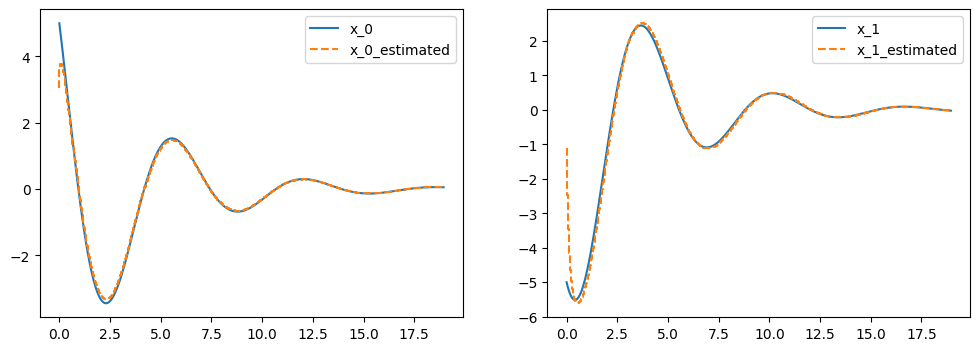

In [63]:
t_span = [0,20]
t_eval = np.arange(*t_span,dt)

I = make_integrator()
g = make_g()

x_init = casadi.DM([5,-5]) # 初期値
y_init = g(x_init)
x0 = casadi.DM.zeros(total)
u_opt = casadi.DM([0.0])
x_hat = casadi.DM([0,0])

X = [x_init]
X_est = []
us = [0]*nu*N
Y = [y_init]
x_current = x_init
for t in t_eval:
    if len(Y) >= N:
        ys = casadi.vertcat(*Y[-N:]).full().ravel().tolist()
        x0 = compute_optimal_estimate(S,us,ys,x0,x_hat)
        x_est = x0[:2]
        X_est.append(x_est)
        x_hat = x_est
    x_current = I(x0=x_current,p=u_opt)["xf"]
    y_current = g(x_current)
    X.append(x_current)
    Y.append(y_current)
    # U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
X_est.pop()
X_est = np.array(X_est).reshape(-1,nx)

plt.figure(figsize=(12,4))

for i in range(nx):
    plt.subplot(1,2,i+1)
    plt.plot(t_eval[:-N],X[:-N,i],label=f"x_{i}")
    plt.step(t_eval[:-N],X_est[:,i],linestyle="--",label=f"x_{i}_estimated")
    plt.legend()

plt.show()